# Bristol-Myers Squibb – Molecular Translation

### Transform skeletal molecular formula into International Chemical Identifier (text)

The images provided (both in the training data as well as the test data) may be rotated to different angles, be at various resolutions, and have different noise levels.

Note: There are about 4m total images in this dataset.

### Output format

image_id,InChI:
* 00000d2a601c,InChI=1S/H2O/h1H2
* 00001f7fc849,InChI=1S/H2O/h1H2
* 000037687605,InChI=1S/H2O/h1H2
* etc.

### InChI

Describe substances in terms of layers of information.
* The atoms and their bond connectivity
* Tautometric information (same number of atoms of each element but different structure)
* Isotope information (particular variant of a chemical element)
* Stereochemestry (spacial arrangement of atoms)
* Electronic charge information 

NOTE: Not all layers have to be provided; for instance, the tautomer layer can be omitted if that type of information is not relevant to the particular application.

The InChI algorithm converts input structural information into a unique InChI identifier in a three-step process:

1. Normalization (to remove redundant information)
2. Canonicalization (to generate a unique number label for each atom)
3. Serialization (to give a string of characters)

#### STRUCTURE

* Every InChI starts with the string "InChI=" followed by the version number, currently 1.
* If the InChI is standard, this is followed by the letter S for standard InChIs, which is a fully standardized InChI flavor maintaining the same level of attention to structure details and the same conventions for drawing perception.
* The remaining information is structured as a sequence of layers and sub-layers, with each layer providing one specific type of information.
* The layers and sub-layers are separated by the delimiter "/" and start with a characteristic prefix letter (except for the chemical formula sub-layer of the main layer).
* The six layers with important sublayers are:

1. Main Layer
Chemical formula (no prefix). This is the only sublayer that must occur in every InChI.
Atom connections (prefix: "c").
    The atoms in the chemical formula (except for hydrogens) are numbered in sequence. This sublayer describes which atoms are connected by bonds to which other ones.
Hydrogen atoms (prefix: "h").
    Describes how many hydrogen atoms are connected to each of the other atoms.

2. Charge Layer
Charge Sublayer (prefix: "q")
Proton Sublayer (prefix: "p")

3. Stereochemical Layer
Double Bonds and Cumulenes (prefix: "b")
Tetrahedral Stereochemistry of Atoms and Allenes (prefixes: "t", "m")
Type of Stereochemistry Information (prefix: "s")

4. Isotopic Layer
prefixes: "i", "h", as well as "b", "t", "m", "s" for isotopic stereochemistry

5. Fixed-H Layer
prefix: "f". NEVER INCLUDED IN STANDARD INCHI

6. Reconnected Layer
prefix: "r". NEVER INCLUDED IN STANDARD INCHI

### Links
* Visualize img_size - https://www.kaggle.com/ihelon/molecular-translation-exploratory-data-analysis
* Visualize InChI data - https://www.kaggle.com/dschettler8845/molecular-translation-eda-smart-baseline
* https://www.kaggle.com/dschettler8845/bms-image-captioning-w-attention-train


* https://www.kaggle.com/yasufuminakama/inchi-preprocess-2
* https://www.kaggle.com/yasufuminakama/inchi-resnet-lstm-with-attention-starter
* https://www.kaggle.com/yasufuminakama/inchi-resnet-lstm-with-attention-inference


* https://www.kaggle.com/markwijkhuizen/tensorflow-tpu-training-baseline-lb-16-92
* https://www.kaggle.com/markwijkhuizen/tensorflow-tpu-training-baseline-predictions

In [17]:
# Machine Learning and Data Science Imports
import tensorflow as tf
import pandas as pd
import numpy as np

# Built In Imports
from collections import Counter
from datetime import datetime
from glob import glob
import warnings
import requests
import imageio
import IPython
import urllib
import zipfile
import pickle
import random
import shutil
import string
import math
import tqdm
import time
import gzip
import ast
import io
import os
import gc
import re
from PIL import Image
import IPython.display as display

In [7]:
!ls

extra_approved_InChIs.csv  test   train_labels.csv
sample_submission.csv	   train  Untitled.ipynb


In [9]:
ALL_ELEMENTS = ["H", " He", " Li", " Be", " B", " C", " N", " O", " F", " Ne", " Na", " Mg", " Al", " Si", " P", 
                "S", " Cl", " Ar", " K", " Ca", " Sc", " Ti", " V", " Cr", " Mn", " Fe", " Co", " Ni", " Cu", " Zn", 
                "Ga", " Ge", " As", " Se", " Br", " Kr", " Rb", " Sr", " Y", " Zr", " Nb", " Mo", " Tc", " Ru", 
                "Rh", " Pd", " Ag", " Cd", " In", " Sn", " Sb", " Te", " I", " Xe", " Cs", " Ba", " La", " Ce", 
                "Pr", " Nd", " Pm", " Sm", " Eu", " Gd", " Tb", " Dy", " Ho", " Er", " Tm", " Yb", " Lu", " Hf", 
                "Ta", " W", " Re", " Os", " Ir", " Pt", " Au", " Hg", " Tl", " Pb", " Bi", " Po", " At", " Rn", 
                "Fr", " Ra", " Ac", " Th", " Pa", " U", " Np", " Pu", " Am", " Cm", " Bk", " Cf", " Es", " Fm", 
                "Md", " No", " Lr", " Rf", " Db", " Sg", " Bh", " Hs", " Mt", " Ds", " Rg", " Cn", " Uut", 
                "Fl", " Uup", " Lv", " Uus", " Uuo"]

# In Order
TRAIN_ELEMENTS = ['C', 'H', 'B', 'Br', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S', 'Si']

# Prefixes and How Common
#      -- ORDERING --> {c}{h/None}{b/None}{t/None}{m/None}{s/None}{i/None}{h/None}{t/None}{m/None}
PREFIX_ORDERING = "chbtmsihtm"

# Define the root and data directories
#ROOT_DIR = "/kaggle/input"
ROOT_DIR = "./"

#DATA_DIR = os.path.join(ROOT_DIR, "bms-molecular-translation")
DATA_DIR = os.path.join(ROOT_DIR, "")

TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

TRAIN_CSV_PATH = os.path.join(DATA_DIR, "train_labels.csv")
SS_CSV_PATH = os.path.join(DATA_DIR, "sample_submission.csv")

train_df = pd.read_csv(TRAIN_CSV_PATH)
train_df["img_path"] = train_df.image_id.apply(lambda x: os.path.join(TRAIN_DIR, x[0], x[1], x[2], x+".png"))
print("\n... TRAIN DATAFRAME W/ PATHS ...\n")
display(train_df)

ss_df = pd.read_csv(SS_CSV_PATH)
print("\n... SUBMISSION DATAFRAME ...\n")
display(ss_df)


... TRAIN DATAFRAME W/ PATHS ...



,image_id,InChI,img_path
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...,./train/0/0/0/000011a64c74.png
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...,./train/0/0/0/000019cc0cd2.png
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...,./train/0/0/0/0000252b6d2b.png
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...,./train/0/0/0/000026b49b7e.png
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...,./train/0/0/0/000026fc6c36.png
...,...,...,...
2424181,ffffe824f539,InChI=1S/C10H12F2N2O3/c1-17-7-2-5(3-8(15)16)9(...,./train/f/f/f/ffffe824f539.png
2424182,ffffea1ebdfa,InChI=1S/C19H20F2N4O3S/c1-10(8-20)28-14-7-12(2...,./train/f/f/f/ffffea1ebdfa.png
2424183,ffffee2b4534,InChI=1S/C22H26Cl2N2O4S/c1-16-6-2-3-10-21(16)3...,./train/f/f/f/ffffee2b4534.png
2424184,fffff0b6eea6,InChI=1S/C17H26N2O6S/c1-23-16-12-14(4-5-15(16)...,./train/f/f/f/fffff0b6eea6.png



... SUBMISSION DATAFRAME ...



,image_id,InChI
0,00000d2a601c,InChI=1S/H2O/h1H2
1,00001f7fc849,InChI=1S/H2O/h1H2
2,000037687605,InChI=1S/H2O/h1H2
3,00004b6d55b6,InChI=1S/H2O/h1H2
4,00004df0fe53,InChI=1S/H2O/h1H2
...,...,...
1616102,ffffcdb2e39e,InChI=1S/H2O/h1H2
1616103,ffffcfddd770,InChI=1S/H2O/h1H2
1616104,ffffe4ab06b2,InChI=1S/H2O/h1H2
1616105,ffffec4033ec,InChI=1S/H2O/h1H2


Example:


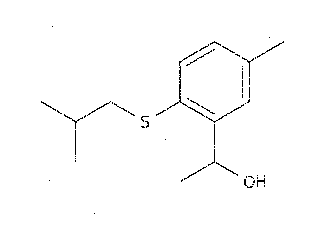

InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12(13)11(4)14/h5-7,9,11,14H,8H2,1-4H3


In [20]:
print("Example:")
display.display(Image.open(train_df.img_path.iloc[0]))
print(train_df.InChI.iloc[0])